Presented by :*KHEDIM IBTISSEM*

Reference : [Fine-Tuning-BERT](https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb)


# Import libraries 

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import time

# specify GPU
device = torch.device("cuda:0")

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#df = pd.read_csv("/content/gdrive/MyDrive/IASD_2/NLP/test.csv")
#Read data
train_path="/content/gdrive/MyDrive/IASD_2/NLP/train.csv"
df_train= pd.read_csv(train_path , header = None)

In [ ]:
test_path="/content/gdrive/MyDrive/IASD_2/NLP/test.csv"
df_test= pd.read_csv(test_path , header = None)

In [ ]:
df_test.head()

,0,1,2
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [ ]:
df_train.shape

(3600000, 3)

# Split train dataset into train, validation and test sets

In [ ]:
df_train['title_text'] = df_train[1] + ' ' + df_train[2]
df_train = df_train.dropna()
df_train = df_train.sample(100000)

In [ ]:
df_test['title_text'] = df_test[1] + ' ' + df_test[2]
df_test = df_test.dropna()
df_test = df_test.sample(20000)

In [ ]:
df_train.head()

,0,1,2,title_text
1120349,1,Archaic Artifact,This is not a practical book for anyone involv...,Archaic Artifact This is not a practical book ...
2529860,2,Excellent,Being deeply spiritual I now understand why we...,Excellent Being deeply spiritual I now underst...
2750328,2,"Just Good and Okay, but not Excellent",I enjoyed playing this immersive adventure to ...,"Just Good and Okay, but not Excellent I enjoye..."
2626716,1,"Great story, bad DVD",Though this is a good story about a very conse...,"Great story, bad DVD Though this is a good sto..."
2493994,2,Stevie Wonder--Definitive Collection,"First of all, Stevie Wonder is an icon. Most o...",Stevie Wonder--Definitive Collection First of ...


In [ ]:
new_labels = {1: 0,
                     2: 1}

In [ ]:
df_train[0] = df_train[0].map(new_labels)

In [ ]:
df_test[0] = df_test[0].map(new_labels)

In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(df_train['title_text'], df_train[0], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df_train[0])
# we will use temp_text and temp_labels to create validation and test set
# val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
#                                                                 random_state=2018, 
#                                                                 test_size=0.5, 
#               

In [ ]:
_, test_text, _, test_labels = train_test_split(df_test['title_text'], df_test[0], 
                                                                    random_state=2018, 
                                                                    test_size=0.99, 
                                                                    stratify=df_test[0])


# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

In [ ]:
# get length of all the messages in the train set
seq_len = [len(k.split()) for k in train_text]

<Axes: >

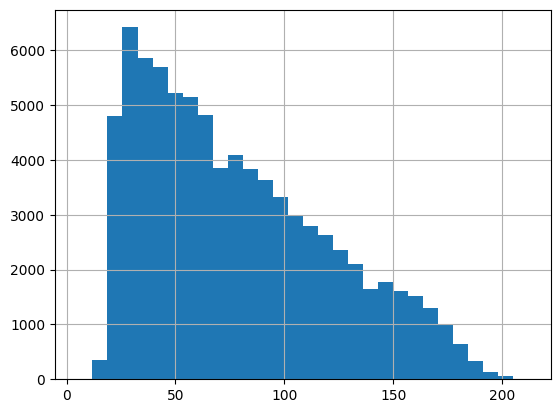

In [ ]:
pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 25

In [ ]:
train_text.tolist()[0:2]

["Tiresome Beware this guide: it is riddled with misinformation (directing one, for example, to the shuttered Bettmann Archive) and other errors of fact and interpretation. It is good on architecture and theater, terrible on literary New York. I couldn't figure who the target audience was--tourists? the newly resettled? --but much of the information is easily available elsewhere, and the 'attitude' is highly tiresome.",
 "Great product Used it on some week old soda pop stains and a fresh cat barf stain with excellent results. Then tried it on a couple ancient dirty oil spots we'd given up on. It took 3 treatments, but they are down to just a shadow of a stain. You really have to look to pick them out. This stuff is the best we've found for spot cleaning carpets, with a reasonable smell and no skin irritation. Great product. Recommended."]

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [ ]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert 
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      # relu activation function
      self.relu =  nn.ReLU()
      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)
    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)
      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

In [ ]:

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels)

print(class_wts)

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
      #elapsed = time.time() - t0      
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')
CUDA_LAUNCH_BLOCKING=1

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of  2,500.
  Batch   100  of  2,500.
  Batch   150  of  2,500.
  Batch   200  of  2,500.
  Batch   250  of  2,500.
  Batch   300  of  2,500.
  Batch   350  of  2,500.
  Batch   400  of  2,500.
  Batch   450  of  2,500.
  Batch   500  of  2,500.
  Batch   550  of  2,500.
  Batch   600  of  2,500.
  Batch   650  of  2,500.
  Batch   700  of  2,500.
  Batch   750  of  2,500.
  Batch   800  of  2,500.
  Batch   850  of  2,500.
  Batch   900  of  2,500.
  Batch   950  of  2,500.
  Batch 1,000  of  2,500.
  Batch 1,050  of  2,500.
  Batch 1,100  of  2,500.
  Batch 1,150  of  2,500.
  Batch 1,200  of  2,500.
  Batch 1,250  of  2,500.
  Batch 1,300  of  2,500.
  Batch 1,350  of  2,500.
  Batch 1,400  of  2,500.
  Batch 1,450  of  2,500.
  Batch 1,500  of  2,500.
  Batch 1,550  of  2,500.
  Batch 1,600  of  2,500.
  Batch 1,650  of  2,500.
  Batch 1,700  of  2,500.
  Batch 1,750  of  2,500.
  Batch 1,800  of  2,500.
  Batch 1,850  of  2,500.
  Batch 1,900  of  2,50

# Load Saved Model

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/IASD_2/NLP/saved_weights.pt')

In [ ]:
#load weights of best model
path = '/content/gdrive/MyDrive/IASD_2/NLP/saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
test_seq2=test_seq.to(device)

In [ ]:
test_mask2=test_mask.to(device)

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  11322 MiB |  11322 MiB |  11762 MiB | 450165 KiB |\n|       from large pool |  11321 MiB |  11321 MiB |  11760 MiB | 449672 KiB |\n|       from small pool |      0 MiB |      0 MiB |      1 MiB |    493 KiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  11322 MiB |  11322 MiB |  11762 MiB | 450165 KiB |\n|       from large pool |  11321 MiB |  11321 MiB |

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq2, test_mask2)
  preds = preds.detach().cpu().numpy()

OutOfMemoryError: ignored

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)